## Evaluate maximum CCD temperature for anneal

For the anneal pathfinder, we defined parameters of the test via previous experience:

 * At -19 C we are comfortable with a 10.3 mag guide star.
 * At +20 C the dark current scales up by a factor of about 32 from the -19 C value. This is based on our best calibration.
 * Using the manufacturer spec indicates a factor more like 45 (based on a factor of 120 increase from 250 K to 300 K).
 * The 6th brightest star in the Pleiades is 4.8 mag (ACA) = 10.3 - 5.5 mags => factor of 150 brighter than 10.3. We can tolerate an increase by a factor of 150 in dark current.
 
While being able to tolerate a factor of 150, we set a conservative limit of 100 as the scale limit.  During the annealing pathfind, the scaling at +8 was seen to scale by more than originally estimated.  However, during the 2016 annealing activity, the scale factor up to +15 was seen to scale less than half as much as predicted via the pathfinder data.

**Using the conservative limit of 100 implies a maximum CCD temperature of +22 C.**

Other results from this analysis:

* Best-fit dark current scaling is a factor of 1.70 increase per 4 C increase.
* A back-of-the-envelope number to remember is a factor of 2 per 5 C (actual is 1.94).
* The slight curvature in scaling seen in the TK1024 spec in a log-linear plot is fitted here but is consistent with zero.

### Solve for scale factor using annealing pathfinder data

In [1]:
from __future__ import division, print_function

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import logging
from scipy.ndimage.filters import median_filter
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sherpa import ui
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime, cxctime2plotdate
from mica.archive.aca_dark.dark_cal import DARK_SCALE_4C

from mica.archive import aca_hdr3
from mica.archive import aca_l0

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


In [4]:
def dark_temp_scale(t_ccd, t_ccd_ref=-19.0, scale_4c=None, scale_quad=0.0):
    """Return the multiplicative scale factor to convert a CCD dark map
    or dark current value from temperature ``t_ccd`` to temperature
    ``t_ccd_ref``::

      dx = (t_ccd_ref - t_ccd) / 4.0
      scale = scale_4c ** dx * exp(scale_quad) ** (dx**2)
      scale = exp(log(scale_4c) * dx + scale_quad * dx**2)

    In other words, if you have a dark current value that corresponds to ``t_ccd``
    and need the value at a different temperature ``t_ccd_ref`` then use the
    the following.  Do not be misled by the misleading parameter names.

      >>> from mica.archive.aca_dark import dark_temp_scale
      >>> scale = dark_temp_scale(t_ccd, t_ccd_ref, scale_4c)
      >>> dark_curr_at_t_ccd_ref = scale * dark_curr_at_t_ccd

    The default value for ``scale_4c`` is 1.0 / 0.7.  It is written this way
    because the equation was previously expressed using 1 / scale_4c with a
    value of 0.7. This value is based on best global fit for dark current model
    in `plot_predicted_warmpix.py`.  This represents the multiplicative change
    in dark current for each 4 degC increase::

      >>> dark_temp_scale(t_ccd=-18, t_ccd_ref=-10, scale_4c=2.0)
      4.0

    :param t_ccd: actual temperature (degC)
    :param t_ccd_ref: reference temperature (degC, default=-19.0)
    :param scale_4c: increase in dark current per 4 degC increase (default=1.0 / 0.7)

    :returns: scale factor
    """
    if scale_4c is None:
        scale_4c = DARK_SCALE_4C
        
    dx = (t_ccd_ref - t_ccd) / 4.0

    return scale_4c**dx * exp(scale_quad)**(dx**2)


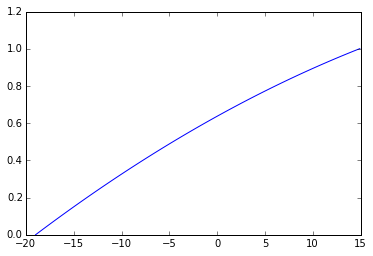

In [5]:
t_ccd = np.arange(-19, 15, .1)
scale = dark_temp_scale(-19.0, t_ccd, scale_quad=-0.01)
plot(t_ccd, log10(scale))

These routines were used during the pathfinder to fit a scale factor to the pixel e-/sec data.

In [6]:
T_CCD_REF = 0  # not -19 # Reference temperature for dark current values in degC          

def dark_scale_model(pars, t_ccd):
    """                                                                          
    dark_t_ref : dark current of a pixel at the reference temperature            
    scale : dark current model scale factor                                      
    returns : dark_t_ref scaled to the observed temperatures t_ccd               
    """
    scale, dark_t_ref, scale_quad = pars
    scaled_dark_t_ref = dark_t_ref * dark_temp_scale(T_CCD_REF, t_ccd, 1 / scale, scale_quad=scale_quad)
    return scaled_dark_t_ref

def fit_pix_values(t_ccd, esec, id=1):
    logger = logging.getLogger("sherpa")
    logger.setLevel(logging.WARNING)
    data_id = id
    ui.set_method('simplex')
    ui.load_user_model(dark_scale_model, 'model')
    ui.add_user_pars('model', ['scale', 'dark_t_ref', 'scale_quad'])
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id,
                   np.array(t_ccd),
                   np.array(esec))
    d = ui.get_data(id)
    d.staterror = 30 * np.ones(len(t_ccd))
    model.scale = 0.70
    model.scale.min = 0.4
    model.scale.max = 1.0
    model.dark_t_ref = 500
    model.dark_t_ref.min = 50
    model.dark_t_ref.max = 5000
    model.scale_quad = -0.00
    model.scale_quad.min = -0.05
    model.scale_quad.max = 0.05
    ui.freeze(model.scale)
    ui.freeze(model.scale_quad)
    # If more than 5 degrees in the temperature range,                           
    # thaw and fit for model.scale.  Else just use/return                        
    # the fit of dark_t_ref                                                      
    if np.max(t_ccd) - np.min(t_ccd) > 2:
        # Fit first for dark_t_ref                                               
        ui.fit(data_id)
        ui.thaw(model.scale)
        # ui.thaw(model.scale_quad)
    ui.fit(data_id)
    return ui.get_fit_results(), ui.get_model(data_id)

Get the data for the interval from the monitor window slots.

In [7]:
slot7 = Table.read("../acaslot7.dat", format='ascii')
start = slot7['time'][slot7['INTEG'] == 0.112][0]
#slot7['TEMPCCD'] = slot7['TEMPCD']

#start = '2015:252:13:00:00.000'
#stop = '2015:252:16:00:00.000'
GAIN = 5.0
#ccd_temp = aca_hdr3.MSID('ccd_temp', start, stop)
#slot6 = aca_l0.get_slot_data(start, stop, 6)
#slot7 = aca_l0.get_slot_data(start, stop, 7)

Run the fits on all pixel with a max median filtered e-/sec count >= 2000

In [8]:
#THRESH = 2000
fits = {}
for slot in [slot7]:
    ok = (slot['TEMPCD'] > -13) # & (slot['TEMPCD'] < 7.5)
    slot = slot[ok]
    t_ccd = slot['TEMPCD']
    for col in ['r7_c5', 'r6_c7', 'r7_c7']:
        esec = slot[col] * GAIN / slot['INTEG']
        #medf_esec = median_filter(esec, 5)
        #if np.max(medf_esec) < THRESH:
        #    continue
        slot_num = slot['IMGNUM1'][0]
        #fit_id = 100 * slot_num + i_col
        fit_id = col
        #print "slot {} pix idx {}".format(slot_num,
        #                                  i_col)
        fit, modpars  = fit_pix_values(t_ccd,
                                       esec,
                                       id=fit_id)
        fits[fit_id] = {'fit': fit,
                        'modpars': modpars,
                        'esec': esec,
                        't_ccd': t_ccd.copy(),
                        'dt': slot['time'] - DateTime(start).secs,
                        't0': DateTime(start).secs}

Plot the fits.

Dataset 0
usermodel.model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model.scale  thawed     0.671189          0.4            1           
   model.dark_t_ref thawed      692.248           50         5000           
   model.scale_quad frozen           -0        -0.05         0.05            

Dataset 1
usermodel.model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model.scale  thawed     0.657503          0.4            1           
   model.dark_t_ref thawed      1060.08           50         5000           
   model.scale_quad frozen           -0        -0.05         0.05            

Dataset 2
usermodel.model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model.scale  thawed    

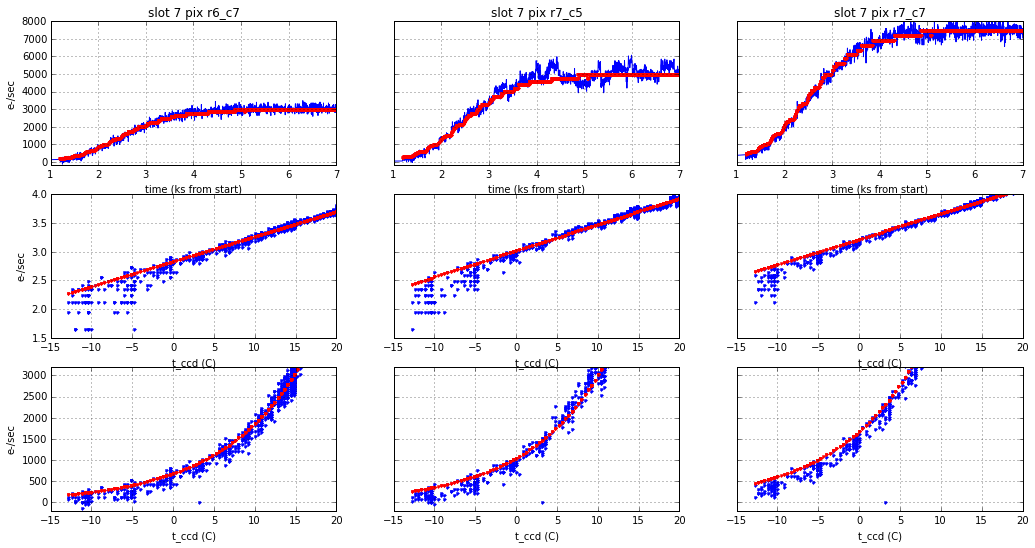

In [9]:
fig, fitaxes = plt.subplots(3, 3, figsize=(15, 8))

for i, fit_id in enumerate(fits):
    modplot = ui.get_model_plot(fit_id)

    timeax = fitaxes[0][i]
    fit = fits[fit_id]
    timeax.plot(fit['dt'] / 1000., fit['esec'], 'b')
    timeax.plot(fit['dt'] / 1000., modplot.y, 'r.')
    timeax.set_xlim(1, 7)
    timeax.set_ylim(-200, 8000)
    timeax.grid()
    timeax.set_xlabel('time (ks from start)')
    timeax.set_title("slot 7 pix {}".format(fit_id))
    #timeax.annotate("scale: {:.3f}".format(fit['modpars'].scale.val),
    #                xy=(0.25, 0.75), xycoords="axes fraction",
    #                ha='center', va='center')
    if i > 0:
        timeax.set_yticklabels([])
    else:
        timeax.set_ylabel("e-/sec")
    fitax = fitaxes[1][i]
    ok = fit['esec'] > 10
    fitax.plot(fit['t_ccd'][ok], log10(fit['esec'][ok]), 'b.')
    print('Dataset {}'.format(i))
    print(fit['modpars'], '\n')
    ok = modplot.y > 10
    fitax.plot(modplot.x[ok], log10(modplot.y[ok]), 'r.')
    fitax.set_ylim(1.5, 4.0)
    fitax.grid()
    fitax.set_xlabel('t_ccd (C)')
    if i > 0:
        fitax.set_yticklabels([])
    else:
        fitax.set_ylabel("e-/sec")

    if i > 0:
        timeax.set_yticklabels([])
    else:
        timeax.set_ylabel("e-/sec")
    fitax = fitaxes[2][i]
    fitax.plot(fit['t_ccd'], fit['esec'], 'b.')
    fitax.plot(modplot.x, modplot.y, 'r.')
    fitax.set_ylim(-200, 3200)
    fitax.grid()
    fitax.set_xlabel('t_ccd (C)')
    if i > 0:
        fitax.set_yticklabels([])
    else:
        fitax.set_ylabel("e-/sec")

fig.subplots_adjust(left=.05, bottom=.1, right=.95, top=.95, wspace=.2, hspace=.2)


### best / only good fits fits are slot 7 63 and slot 7 18                                          
best_fits = [763, 718]
scale = np.mean([fits[i]['modpars'].scale.val for i in best_fits])
print(scale)

In [10]:
print("The scale factor demonstrated in the pathfinder data is {:0.3f}".format(scale))

ValueError: Unknown format code 'f' for object of type 'str'

This scale factor represents the multiplicative change in dark current for each 4 degC decrease.  

## Expected scale change based on new scale factor

We plug this new scale factor back into the "dark_temp_scale" routine. Given an initial temperature, a final temperature, and a scale factor, that routine returns the scale change from the initial temperature to the final temperature.  Below, I've plotted the scale change from -19C to the range of temperatures from -19C to +20C.


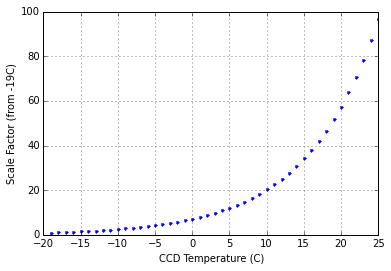

In [16]:
scale = 0.66
plot(np.arange(-19, 26), dark_temp_scale(-19, np.arange(-19, 26), scale_4c = 1.0 / scale), 'b.')
xlabel("CCD Temperature (C)")
ylabel("Scale Factor (from -19C)")
grid('on')

## Setting a limit temperature for the anneal

The plot above is largely a graphical representation of the parameters / rules-of-thumb that we started with:

* At -19 C we are comfortable with a 10.3 mag guide star.
* The 6th brightest star in the Pleiades is 4.8 mag (ACA) = 10.3 - 5.5 mags => factor of 150 brighter than 10.3. We can tolerate an increase by a factor of 150 in dark current.
* A change by a factor of 100 is a conservative limit

But the solved-for scale factor defines the curve instead of our original scale factor estimates.

Below, I've replotted the scale change from -19 to X, but added the limit line at 100.

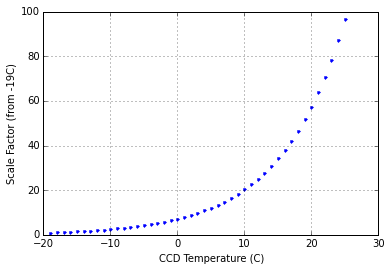

In [17]:
plot(np.arange(-19, 26), dark_temp_scale(-19, np.arange(-19, 26), scale_4c = 1.0 / scale), 'b.')
xlabel("CCD Temperature (C)")
ylabel("Scale Factor (from -19C)")
grid('on')
plot([-19, 26], [100, 100]);

Maximum temperature, then, is 22.2 deg C to stay under the 100 overall scale limit.

In [18]:
print("The estimated scale change from -19C to +22.2C is {:.4f}"
      .format(dark_temp_scale(-19, 22.2, scale_4c = 1.0 / scale)))

The estimated scale change from -19C to +22.2C is 72.2266


In [19]:
print("The estimated scale change from -19 to +20C is {:.4f}"
      .format(dark_temp_scale(-19, 20, scale_4c = 1.0 / scale)))

The estimated scale change from -19 to +20C is 57.4707


That is more than our original estimates of 32 (from our own calibration) or 45 (from manufacturer spec), but less than the estimate of 177 based on the pathfinder data.

In [20]:
print("The estimated scale change from -19 to +30C is {:.4f}"
      .format(dark_temp_scale(-19, 30, scale_4c = 1.0 / scale)))

The estimated scale change from -19 to +30C is 162.4003
